In [57]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'cs231n/assignments/assignment3/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment3/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment3


## Using GPU

Go to `Runtime > Change runtime type` and set `Hardware accelerator` to `GPU`. This will reset Colab. **Rerun the top cell to mount your Drive again.**

# Generative Adversarial Networks (GANs)

So far in CS 231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we had learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$) and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will alternate between taking gradient *descent* steps on the objective for $G$ and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__.
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Here's an example of what your outputs from the 3 different models you're going to train should look like. Note that GANs are sometimes finicky, so your outputs might not look exactly like this. This is just meant to be a *rough* guideline of the kind of quality you can expect:

# 生成对抗网络 (GAN)

到目前为止，在 CS 231N 课程中，我们探索的所有神经网络应用都是**判别模型**，它们接受输入并经过训练产生带标签的输出。这些应用范围广泛，从简单的图像类别分类到句子生成（这仍然被表述为分类问题，我们的标签位于词汇空间中，并且我们学习了一个递归函数来捕获多词标签）。在本笔记中，我们将扩展我们的知识储备，并使用神经网络构建**生成模型**。具体来说，我们将学习如何构建能够生成与一组训练图像相似的新图像的模型。

### 什么是 GAN？

2014 年，[Goodfellow 等人](https://arxiv.org/abs/1406.2661) 提出了一种训练生成模型的方法，称为生成对抗网络（简称 GAN）。在 GAN 中，我们构建了两个不同的神经网络。我们的第一个网络是一个传统的分类网络，称为**鉴别器**。我们将训练鉴别器拍摄图像并将其分类为真实图像（属于训练集）或伪造图像（不存在于训练集中）。我们的另一个网络称为**生成器**，它将以随机噪声作为输入，并使用神经网络对其进行转换以生成图像。生成器的目标是欺骗鉴别器，使其误以为它生成的图像是真实的。

我们可以将生成器 ($G$) 试图欺骗鉴别器 ($D$) 以及鉴别器试图正确区分真假图像的来回过程想象成一个极小极大博弈：
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
其中 $z \sim p(z)$ 为随机噪声样本，$G(z)$ 为使用神经网络生成器 $G$ 生成的图像，$D$ 为鉴别器的输出，表示输入为实数的概率。在 [Goodfellow 等人](https://arxiv.org/abs/1406.2661) 中，他们分析了这个极小极大博弈，并展示了它与最小化训练数据分布和 $G$ 生成的样本之间的 Jensen-Shannon 散度之间的关系。

为了优化这个极小极大博弈，我们将交替对目标函数 $G$ 进行梯度*下降*，并对目标函数 $D$ 进行梯度*上升*：
1. 更新**生成器** ($G$)，以最小化__判别器做出正确选择的概率__。
2. 更新**判别器** ($D$)，以最大化__判别器做出正确选择的概率__。

虽然这些更新对于分析很有用，但在实践中效果不佳。因此，我们将在更新生成器时使用不同的目标：最大化**判别器做出错误选择的概率**。这个小小的改变有助于缓解判别器置信度较高时生成器梯度消失的问题。这是大多数 GAN 论文中使用的标准更新方法，[Goodfellow 等人](https://arxiv.org/abs/1406.2661) 的原始论文中也使用了这种方法。

在本次作业中，我们将交替进行以下更新：
1. 更新生成器 ($G$)，使判别器在生成数据上做出错误选择的概率最大化：
$$\underset{G}{\text{maximize}}\; \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. 更新判别器 ($D$)，使判别器在真实数据和生成数据上做出正确选择的概率最大化：
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

以下是你将要训练的三个不同模型的输出示例。请注意，GAN 有时比较挑剔，所以你的输出结果可能与此不同。这只是一个粗略的指导，你可以预期其质量：

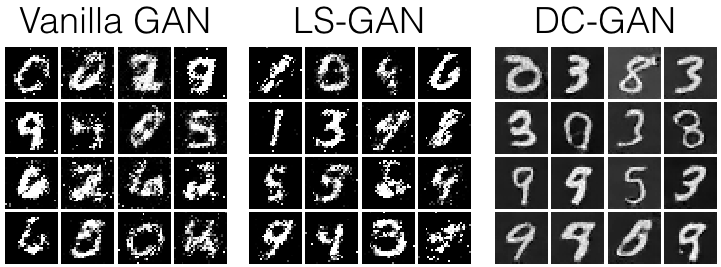

In [58]:
# Run this cell to see sample outputs.
from IPython.display import Image
Image('images/gan_outputs_pytorch.png')

In [59]:
# Setup cell.
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cs231n.gan_pytorch import preprocess_img, deprocess_img, rel_error, count_params, ChunkSampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1]) # Images reshape to (batch_size, D).
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

answers = dict(np.load('gan-checks.npz'))
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`.

## 数据集
GAN 对超参数的挑剔程度众所周知，而且需要大量的训练周期。为了使这项作业更容易上手，我们将使用 MNIST 数据集，该数据集包含 60,000 张训练图像和 10,000 张测试图像。每张图片都包含一张居中图像，图像的白色数字位于黑色背景上（数字 0 到 9）。这是最早用于训练卷积神经网络的数据集之一，而且相当容易——一个标准的 CNN 模型可以轻松达到 99% 以上的准确率。

为了简化代码，我们将使用 PyTorch MNIST 包装器，它可以下载并加载 MNIST 数据集。有关接口的更多信息，请参阅[文档](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py)。默认参数将采用 5,000 个训练样本并将其放入验证数据集中。数据将保存到名为“MNIST_data”的文件夹中。

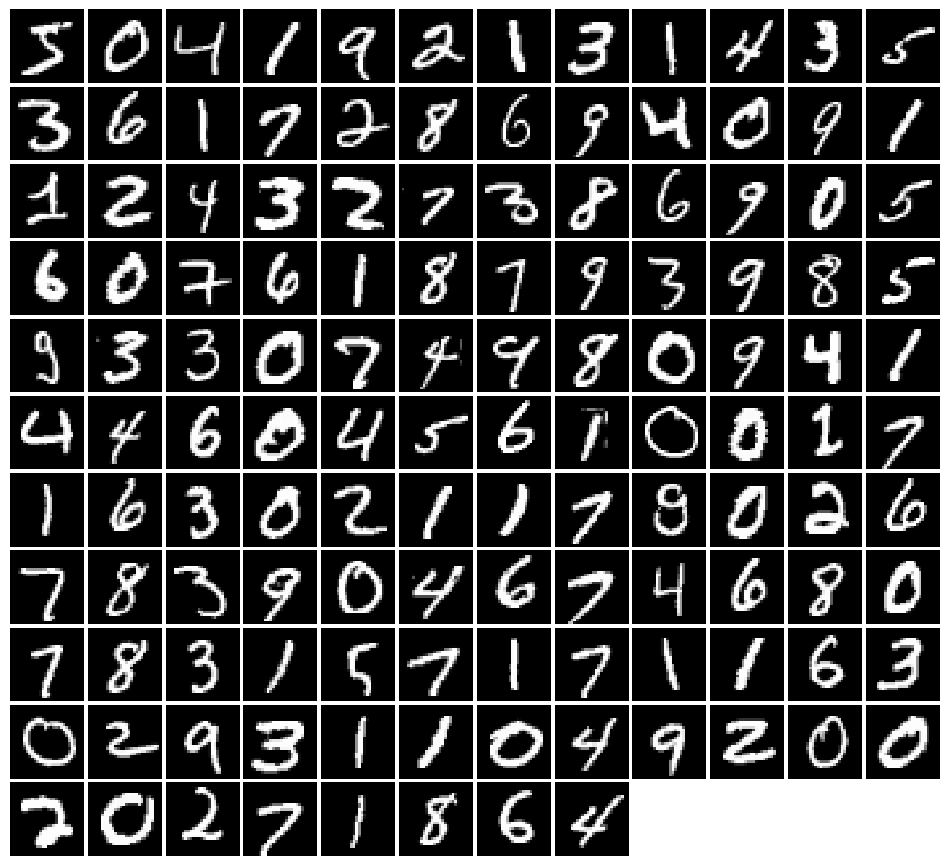

In [60]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_TRAIN, 0)
)

mnist_val = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_val = DataLoader(
    mnist_val,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_VAL, NUM_TRAIN)
)

iterator = iter(loader_train)
imgs, labels = next(iterator)
imgs = imgs.view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Implement `sample_noise` in `cs231n/gan_pytorch.py`.

Hint: use `torch.rand`.

Make sure noise is the correct shape and type:

## 随机噪声
生成形状为 `[batch_size, dim]`，取值范围从 -1 到 1 的均匀噪声。

在 `cs231n/gan_pytorch.py​​` 中实现 `sample_noise`。

提示：使用 `torch.rand`。

确保噪声的形状和类型正确：

In [61]:
from cs231n.gan_pytorch import sample_noise

def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')

test_sample_noise()

All tests passed!


## Flatten

Recall our Flatten operation from previous notebooks... this time we also provide an Unflatten, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

## 扁平化

回想一下之前笔记本中的扁平化操作……这次我们还提供了一个反扁平化操作，你可能在实现卷积生成器时会用到它。我们还提供了一个权重初始化器（并为你调用它），它使用 Xavier 初始化方法，而不是 PyTorch 的统一默认值。

In [62]:
from cs231n.gan_pytorch import Flatten, Unflatten, initialize_weights

# Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1

Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.

The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

Implement `discriminator` in `cs231n/gan_pytorch.py`

# 判别器
我们的第一步是构建一个判别器。在下面的函数中，将架构作为 `nn.Sequential` 构造函数的一部分填写。所有全连接层都应包含偏差项。架构如下：
* 输入大小为 784、输出大小为 256 的全连接层
* alpha 值为 0.01 的 LeakyReLU
* 输入大小为 256、输出大小为 256 的全连接层
* alpha 值为 0.01 的 LeakyReLU
* 输入大小为 256、输出大小为 1 的全连接层

回想一下，Leaky ReLU 非线性函数计算 $f(x) = \max(\alpha x, x)$，其中 alpha 为某个常数；对于上述架构中的 LeakyReLU 非线性函数，我们设定 alpha=0.01。

鉴别器的输出应具有 `[batch_size, 1]` 的形状，并包含与 `batch_size` 个输入对应的分数（表示每个输入都是一张真实图像）对应的实数。

在 `cs231n/gan_pytorch.py​​` 中实现 `discriminator`

Test to make sure the number of parameters in the discriminator is correct:

In [63]:
from cs231n.gan_pytorch import discriminator

def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')

test_discriminator()

Correct number of parameters in discriminator.


# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

 Implement `generator` in `cs231n/gan_pytorch.py`

 # 生成器
现在构建生成器网络：
* 从 noise_dim 到 1024 的全连接层
* `ReLU`
* 大小为 1024 的全连接层
* `ReLU`
* 大小为 784 的全连接层
* `TanH`（将图像裁剪到 [-1,1] 范围内）

在 `cs231n/gan_pytorch.py​​` 中实现 `generator`

Test to make sure the number of parameters in the generator is correct:

In [64]:
from cs231n.gan_pytorch import generator

def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation that relies on PyTorch's `nn.BCEWithLogitsLoss`.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`true_labels = torch.ones(size).type(dtype)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch. This is taken care of in `bce_loss` which combines the loss by averaging.

Implement `discriminator_loss` and `generator_loss` in `cs231n/gan_pytorch.py`

# GAN 损失

计算生成器和鉴别器的损失。生成器损失为：
$$\ell_G = -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
鉴别器的损失为：
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
请注意，这些损失已从之前给出的方程式中取反，因为我们将*最小化*这些损失。

**提示**：你应该使用下面定义的 `bce_loss` 函数来计算二元交叉熵损失，该损失用于计算给定鉴别器输出的对数样本对应的真实标签的对数概率。给定一个分数 $s\in\mathbb{R}$ 和一个标签 $y\in\{0, 1\}$，二元交叉熵损失为

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

此公式的简单实现可能存在数值不稳定的问题，因此我们提供了一个基于 PyTorch 的 `nn.BCEWithLogitsLoss` 的数值稳定实现。

您还需要计算与真假对应的标签，并使用 logit 参数确定它们的大小。确保使用全局 `dtype` 变量将这些标签转换为正确的数据类型，例如：

`true_labels = torch.ones(size).type(dtype)`

我们不会计算 $\log D(G(z))$、$\log D(x)$ 和 $\log \left(1-D(G(z))\right)$ 的期望值，而是对小批量的元素进行平均。这由 `bce_loss` 处理，它会通过平均合并损失。

在 `cs231n/gan_pytorch.py​​` 中实现 `discriminator_loss` 和 `generator_loss`

Test your generator and discriminator loss. You should see errors < 1e-7.

In [65]:
from cs231n.gan_pytorch import bce_loss, discriminator_loss, generator_loss

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_true']
)

Maximum error in d_loss: 3.97058e-09


In [66]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(
    answers['logits_fake'],
    answers['g_loss_true']
)

Maximum error in g_loss: 4.4518e-09


# Optimizing our Loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

Implement `get_optimizer` in `cs231n/gan_pytorch.py`

# 优化损失
创建一个函数，返回一个 `optim.Adam` 优化器，该优化器针对给定的模型，学习率为 1e-3，beta1=0.5，beta2=0.999。你将使用它来为本笔记本其余部分的生成器和鉴别器构建优化器。

在 `cs231n/gan_pytorch.py​​` 中实现 `get_optimizer`

# Training a GAN!

We provide you the main training loop. You won't need to change `run_a_gan` in `cs231n/gan_pytorch.py`, but we encourage you to read through it for your own understanding.

In [67]:
from cs231n.gan_pytorch import get_optimizer, run_a_gan

# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

# Run it!
images = run_a_gan(
    D,
    G,
    D_solver,
    G_solver,
    discriminator_loss,
    generator_loss,
    loader_train
)

Iter: 0, D: 1.432, G:0.4791
Iter: 250, D: 1.388, G:0.6924
Iter: 500, D: 1.386, G:0.6931
Iter: 750, D: 1.386, G:0.6931
Iter: 1000, D: 1.386, G:0.6931
Iter: 1250, D: 1.386, G:0.6931
Iter: 1500, D: 1.386, G:0.6931
Iter: 1750, D: 1.386, G:0.6931
Iter: 2000, D: 1.386, G:0.6931
Iter: 2250, D: 1.386, G:0.6931
Iter: 2500, D: 1.386, G:0.6931
Iter: 2750, D: 1.386, G:0.6931
Iter: 3000, D: 1.386, G:0.6931
Iter: 3250, D: 1.386, G:0.6931
Iter: 3500, D: 1.386, G:0.6931
Iter: 3750, D: 1.386, G:0.6931


Run the cell below to show the generated images.

Iter: 0


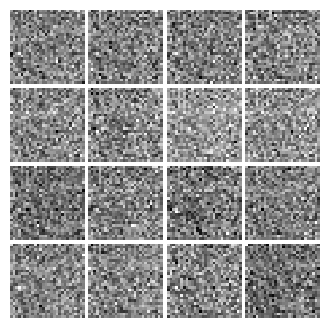


Iter: 250


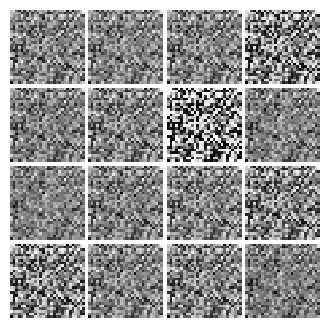


Iter: 500


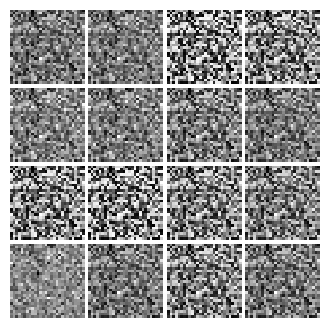


Iter: 750


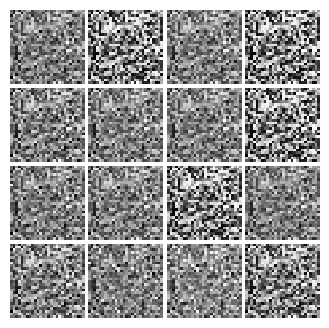


Iter: 1000


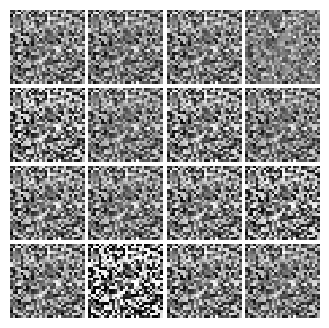


Iter: 1250


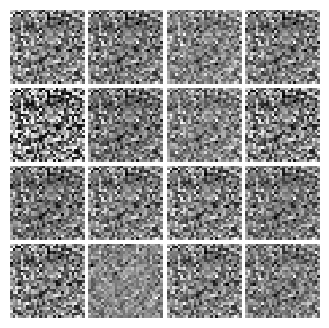


Iter: 1500


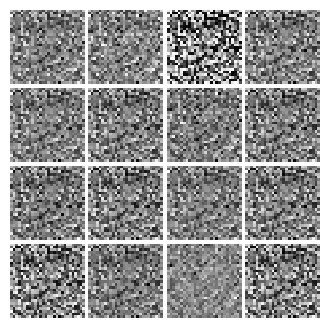


Iter: 1750


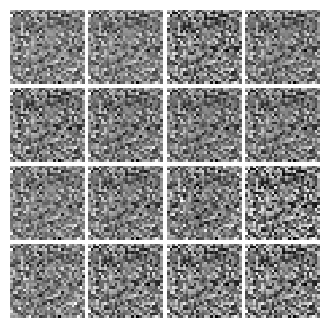


Iter: 2000


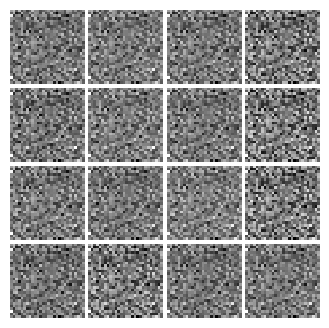


Iter: 2250


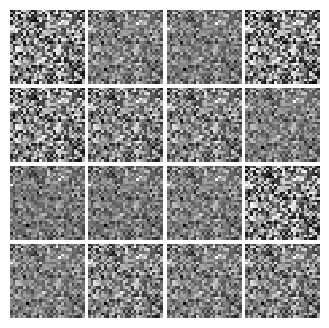


Iter: 2500


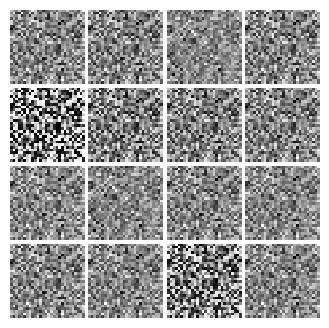


Iter: 2750


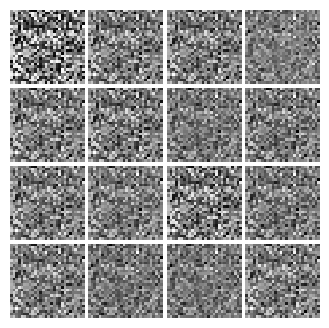


Iter: 3000


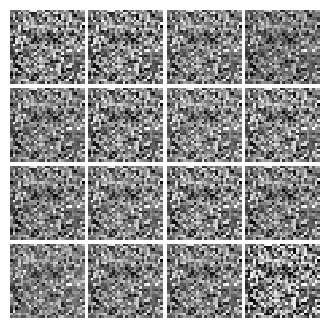


Iter: 3250


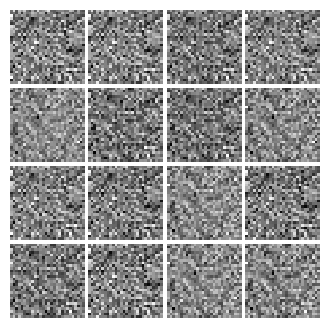


Iter: 3500


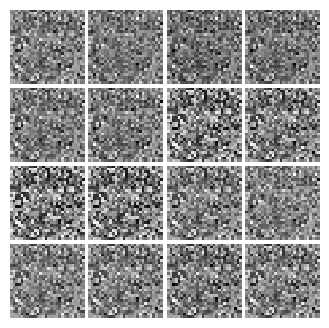


Iter: 3750


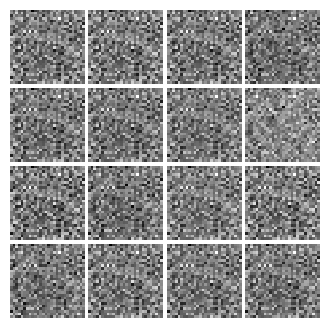

In [68]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 1

What does your final vanilla GAN image look like?

Vanilla GAN final image:


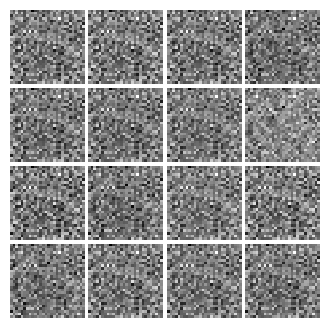

In [69]:
# This output is your answer.
print("Vanilla GAN final image:")
show_images(images[-1])
plt.show()

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

嗯，这并不难，不是吗？在 100 次迭代中，你应该能看到黑色背景，接近 1000 次迭代时，形状会变得模糊，而当迭代次数超过 3000 次时，大约一半的形状会变得清晰锐利。

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

Implement `ls_discriminator_loss`, `ls_generator_loss` in `cs231n/gan_pytorch.py`

# 最小二乘 GAN
现在我们来看一下 [最小二乘 GAN](https://arxiv.org/abs/1611.04076)，它是原始 GAN 损失函数的一个更新、更稳定的替代方案。在这一部分，我们只需要更改损失函数并重新训练模型即可。我们将实现论文中的公式 (9)，生成器损失为：
$$\ell_G = \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
鉴别器损失为：
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

**提示**：我们将对小批量数据中的元素取平均值，而不是计算期望值，因此请确保通过平均而不是求和来合并损失。当代入 $D(x)$ 和 $D(G(z))$ 时，请使用判别器的直接输出（“scores_real” 和 “scores_fake”）。

在“cs231n/gan_pytorch.py​​”中实现“ls_discriminator_loss”和“ls_generator_loss”。

Before running a GAN with our new loss function, let's check it:

In [70]:
from cs231n.gan_pytorch import ls_discriminator_loss, ls_generator_loss

def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_lsgan_true'],
    answers['g_loss_lsgan_true']
)

Maximum error in d_loss: 1.53171e-08
Maximum error in g_loss: 2.7837e-09


Run the following cell to train your model!

In [71]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

images = run_a_gan(
    D_LS,
    G_LS,
    D_LS_solver,
    G_LS_solver,
    ls_discriminator_loss,
    ls_generator_loss,
    loader_train
)

Iter: 0, D: 0.2538, G:0.1292
Iter: 250, D: 0.2415, G:0.1801
Iter: 500, D: 0.1795, G:0.2586
Iter: 750, D: 0.1919, G:0.2836
Iter: 1000, D: 0.2278, G:0.2378
Iter: 1250, D: 0.2418, G:0.2362
Iter: 1500, D: 0.231, G:0.1856
Iter: 1750, D: 0.2189, G:0.3183
Iter: 2000, D: 0.1911, G:0.1735
Iter: 2250, D: 0.2254, G:0.171
Iter: 2500, D: 0.2161, G:0.2078
Iter: 2750, D: 0.2219, G:0.2108
Iter: 3000, D: 0.2037, G:0.1485
Iter: 3250, D: 0.2485, G:0.1736
Iter: 3500, D: 0.2387, G:0.2169
Iter: 3750, D: 0.2423, G:0.1691


Run the cell below to show generated images.

Iter: 0


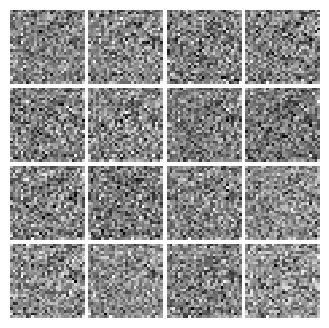


Iter: 250


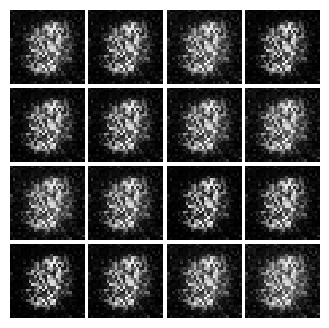


Iter: 500


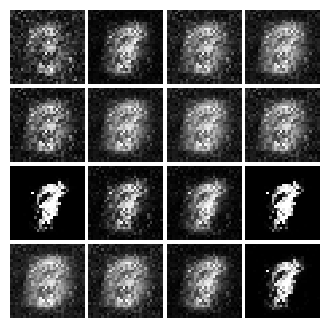


Iter: 750


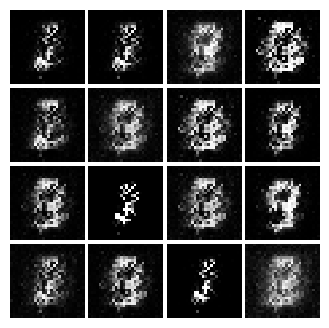


Iter: 1000


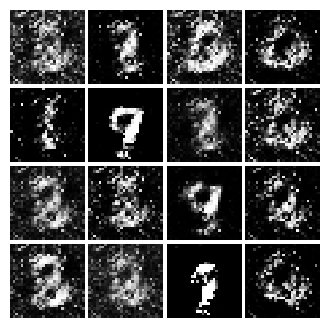


Iter: 1250


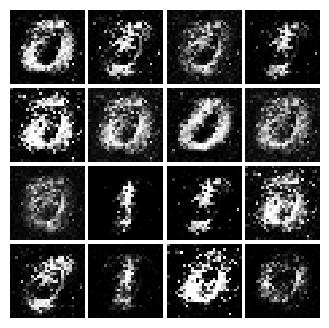


Iter: 1500


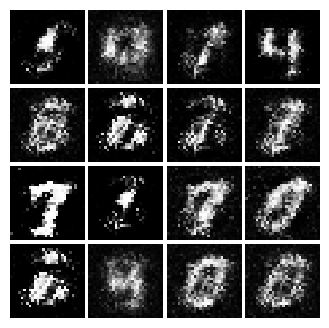


Iter: 1750


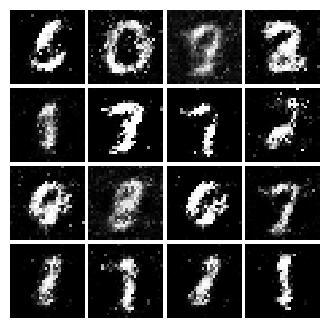


Iter: 2000


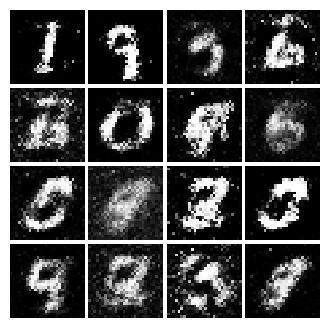


Iter: 2250


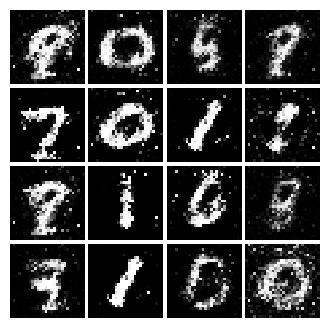


Iter: 2500


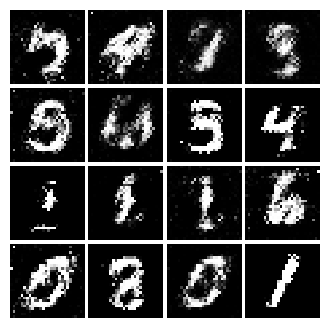


Iter: 2750


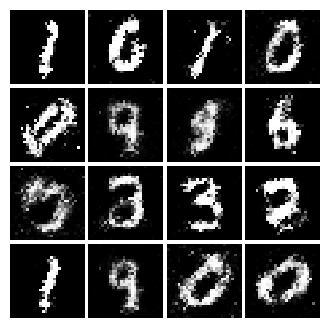


Iter: 3000


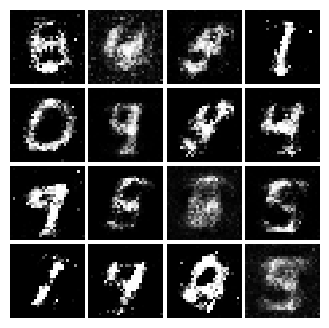


Iter: 3250


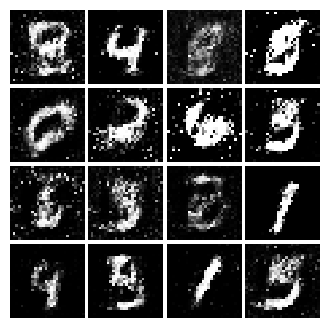


Iter: 3500


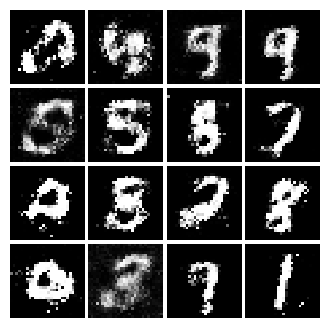


Iter: 3750


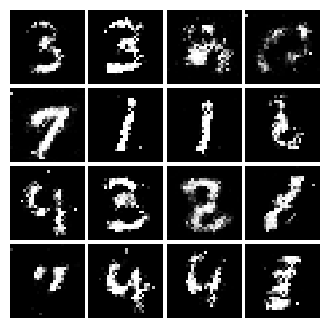

In [72]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 2

What does your final LSGAN image look like?

LSGAN final image:


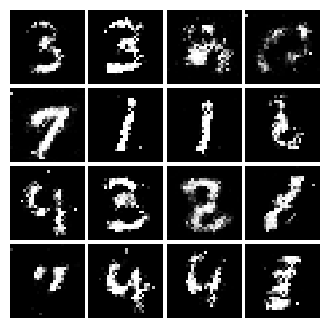

In [73]:
# This output is your answer.
print("LSGAN final image:")
show_images(images[-1])
plt.show()

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly.
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Implement `build_dc_classifier` in `cs231n/gan_pytorch.py`

1,002 / 5,000
# 深度卷积 GAN
在笔记的第一部分，我们几乎直接复制了 Ian Goodfellow 的原始 GAN 网络。然而，这种网络架构无法进行真正的空间推理。由于缺乏卷积层，它通常无法推理诸如“锐利边缘”之类的问题。因此，在本节中，我们将实现 [DCGAN](https://arxiv.org/abs/1511.06434) 中的一些想法，其中我们使用了卷积网络。

#### 判别器
我们将使用一个受 TensorFlow MNIST 分类教程启发的判别器，它能够在 MNIST 数据集上快速获得 99% 以上的准确率。
* 卷积核 2D：32 个滤波器，5x5，步长 1
* 泄漏 ReLU（alpha=0.01）
* 最大池化 2x2，步长 2
* 卷积核 2D：64 个滤波器，5x5，步长 1
* 泄漏 ReLU（alpha=0.01）
* 最大池化 2x2，步长 2
* 扁平化
* 全连接，输出尺寸 4 x 4 x 64
* 泄漏 ReLU（alpha=0.01）
* 全连接，输出尺寸 1

在 `cs231n/gan_pytorch.py​​` 中实现 `build_dc_classifier`

In [74]:
from cs231n.gan_pytorch import build_dc_classifier

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier(batch_size).type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [75]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier(batch_size)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in classifier. Check your achitecture.')
    else:
        print('Correct number of parameters in classifier.')

test_dc_classifer()

Correct number of parameters in classifier.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). We are always "training" in GAN mode.
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128
* ReLU
* BatchNorm
* Use `Unflatten()` to reshape into Image Tensor of shape 7, 7, 128
* ConvTranspose2d: 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* ConvTranspose2d: 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector (using `Flatten()`)

Implement `build_dc_generator` in `cs231n/gan_pytorch.py`

#### 生成器
对于生成器，我们将完全复制 [InfoGAN 论文](https://arxiv.org/pdf/1606.03657.pdf) 中的架构。请参阅附录 C.1 MNIST。请参阅 [nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) 的文档。我们始终在 GAN 模式下进行“训练”。
* 全连接，输出尺寸为 1024
* `ReLU`
* BatchNorm
* 全连接，输出尺寸为 7 x 7 x 128
* ReLU
* BatchNorm
* 使用 `Unflatten()` 将图像张量重塑为尺寸为 7、7、128
* ConvTranspose2d：64 个 4x4 滤波器，步长为 2，填充相同（使用 `padding=1`）
* `ReLU`
* BatchNorm
* ConvTranspose2d：1 个 4x4 滤波器，步长为 2，填充相同（使用 `padding=1`）
* `TanH`
* 应为 28x28x1 的图像，重塑为尺寸为 784 的向量（使用 `Flatten()`）

在 `cs231n/gan_pytorch.py​​` 中实现 `build_dc_generator`

In [76]:
from cs231n.gan_pytorch import build_dc_generator

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Check the number of parameters in your generator as a sanity check:

In [77]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


In [78]:
D_DC = build_dc_classifier(batch_size).type(dtype)
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(
    D_DC,
    G_DC,
    D_DC_solver,
    G_DC_solver,
    discriminator_loss,
    generator_loss,
    loader_train,
    num_epochs=5
)

Iter: 0, D: 1.403, G:1.433
Iter: 250, D: 1.408, G:1.063
Iter: 500, D: 1.23, G:1.336
Iter: 750, D: 1.133, G:0.8551
Iter: 1000, D: 1.253, G:1.071
Iter: 1250, D: 1.208, G:1.03
Iter: 1500, D: 1.088, G:0.9587
Iter: 1750, D: 0.9707, G:1.231


Run the cell below to show generated images.

Iter: 0


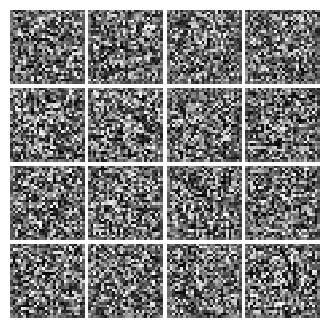


Iter: 250


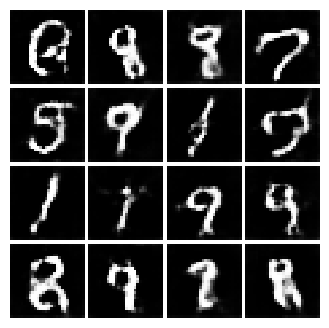


Iter: 500


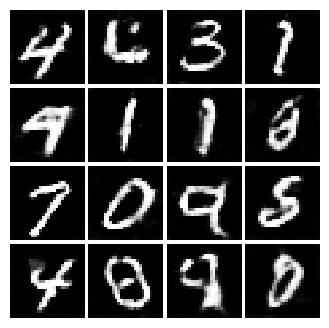


Iter: 750


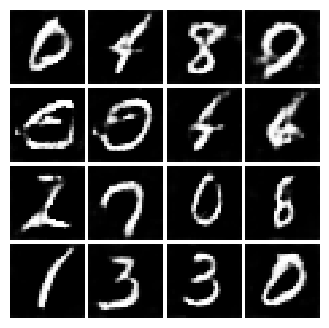


Iter: 1000


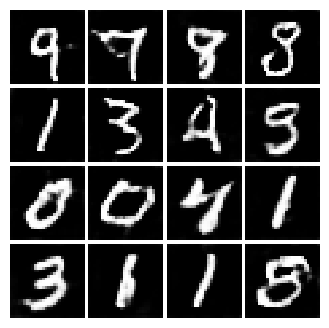


Iter: 1250


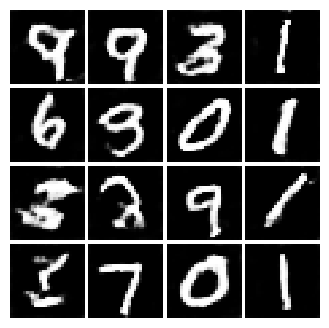


Iter: 1500


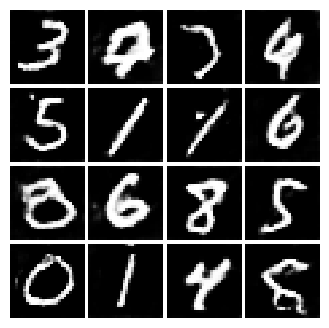


Iter: 1750


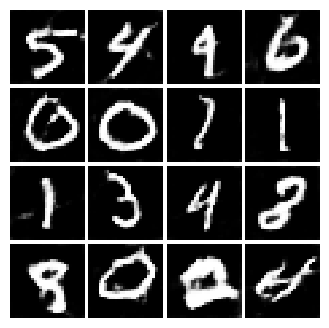

In [79]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 3

What does your final DCGAN image look like?

DCGAN final image:


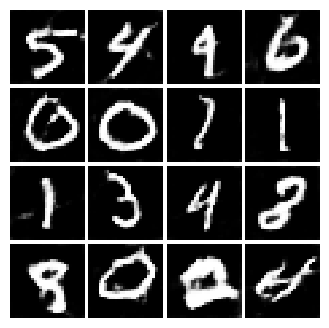

In [80]:
# This output is your answer.
print("DCGAN final image:")
show_images(images[-1])
plt.show()

## Inline Question 4

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$,
by using alternating gradient (first updating y, then updating x using that updated y) with step size $1$. **Here step size is the learning_rate, and steps will be learning_rate * gradient.**
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Breifly explain what $\min_x\max_y f(x,y)$ evaluates to and record the six pairs of explicit values for $(x_t,y_t)$ in the table below.

### Your answer:


 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$
 ----- | ----- | ----- | ----- | ----- | ----- | -----
   1   |       |       |       |       |       |       
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$
   1   |       |       |       |       |       |       
   
## 内联问题 4

我们将通过一个例子来解释为什么对同一目标进行交替最小化（例如在 GAN 中）会非常棘手。

考虑 $f(x,y)=xy$。$\min_x\max_y f(x,y)$ 的结果是多少？（提示：minmax 试图最小化可实现的最大值。）

现在尝试从点 $(1,1)$ 开始，用 6 步数值计算该函数，
使用交替梯度法（先更新 y，然后用更新后的 y 更新 x），步长为 $1$。**这里的步长是学习速率，步长为学习速率 * 梯度。**
你会发现，用 $x_t,y_t,x_{t+1},y_{t+1}$ 的形式写出更新步骤会很有用。

简要解释 $\min_x\max_y f(x,y)$ 的结果，并在下表中记录 $(x_t,y_t)$ 的六对显式值。

### 你的答案：

$y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$
----- | ----- | ----- | ----- | ----- | ----- | -----
1 |2 |1 |-1 |-2 |-1 |1
$x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$
1 |-1 |-2 |-1 |1 |2 |1



## Inline Question 5
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer:

结果参数在正负之间来回震荡，无法收敛

## Inline Question 6
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient.

### Your answer:

## 内联问题 6
如果生成器损失在训练过程中下降，而鉴别器损失从一开始就保持在一个恒定的高值，这是一个好兆头吗？为什么？或者为什么不？一个定性的答案就足够了。

并非一个好兆头，因为这是对抗失衡的典型表现​

### 你的答案：